## Sharpened Cosine Similarity

For signal $s$ and kernel $k$

$CosSim(s, k) = sign(s⋅k) \left ( \frac{\|s⋅k\|}{\|s\| \|k\|} \right )^p$

In [9]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.layers as layers

In [ ]:
batch_size = 1024
epochs = 100
n_fits = 1000
lr = .05
label_smoothing = .3


In [10]:

# Taken from Raphael Pisoni's implementation,
# https://colab.research.google.com/drive/1Lo-P_lMbw3t2RTwpzy1p8h0uKjkCx-RB
# with only a couple of minor tweaks.
class CosSim2D(layers.Layer):
    def __init__(
        self,
        depthwise_separable=False,
        epsilon=1e-12,
        kernel=1,
        padding='valid',
        stride=1,
        units=32,
    ):
        super(CosSim2D, self).__init__()

        self.depthwise_separable = depthwise_separable
        self.epsilon = epsilon
        self.units = units
        self.stride = stride

        assert kernel in [1, 3, 5], "kernel of this size not supported"
        self.kernel_size = kernel
        if self.kernel_size == 1:
            self.stack = lambda x: x
        elif self.kernel_size == 3:
            self.stack = self.stack3x3
        elif self.kernel_size == 5:
            self.stack = self.stack5x5

        if padding == 'same':
            self.pad = self.kernel_size // 2
            self.pad_1 = 1
            self.clip = 0
        elif padding == 'valid':
            self.pad = 0
            self.pad_1 = 0
            self.clip = self.kernel_size // 2

    def build(self, input_shape):
        self.in_shape = input_shape
        self.out_y = math.ceil((self.in_shape[1] - 2*self.clip) / self.stride)
        self.out_x = math.ceil((self.in_shape[2] - 2*self.clip) / self.stride)
        self.flat_size = self.out_x * self.out_y
        self.channels = self.in_shape[3]

        if self.depthwise_separable:
            self.w = self.add_weight(
                shape=(1, tf.square(self.kernel_size), self.units),
                initializer="glorot_uniform",
                name='w',
                trainable=True,
            )
        else:
            w_shape = (
                1, self.channels * tf.square(self.kernel_size), self.units)
            self.w = self.add_weight(
                shape=w_shape,
                initializer="glorot_uniform",
                name='w',
                trainable=True,
            )

        p_init = tf.keras.initializers.Constant(value=2)
        self.p = self.add_weight(
            shape=(self.units,), initializer=p_init, trainable=True, name='p')

    @tf.function
    def l2_normal(self, x, axis=None, epsilon=1e-12):
        square_sum = tf.reduce_sum(tf.square(x), axis, keepdims=True)
        x_inv_norm = tf.sqrt(tf.maximum(square_sum, epsilon))
        return x_inv_norm

    @tf.function
    def sigplus(self, x):
        return tf.nn.sigmoid(x) * tf.nn.softplus(x)

    @tf.function
    def stack3x3(self, image):
        x = tf.shape(image)[2]
        y = tf.shape(image)[1]
        stack = tf.stack([
            # top row
            tf.pad(image[:, :y - 1 - self.clip:, :x - 1 - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 1 - self.clip, self.clip:x - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [0, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 1 - self.clip, 1 + self.clip:, :], tf.constant([[0, 0], [self.pad, 0], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :],

            # middle row
            tf.pad(image[:, self.clip:y - self.clip, :x - 1 - self.clip, :], tf.constant([[0, 0], [0, 0], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            image[:, self.clip:y - self.clip:self.stride, self.clip:x - self.clip:self.stride, :],
            tf.pad(image[:, self.clip:y - self.clip, 1 + self.clip:, :], tf.constant([[0, 0], [0, 0], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :],

            # bottom row
            tf.pad(image[:, 1 + self.clip:, :x - 1 - self.clip, :], tf.constant([[0, 0], [0, self.pad], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:, self.clip:x - self.clip, :], tf.constant([[0, 0], [0, self.pad], [0, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:, 1 + self.clip:, :], tf.constant([[0, 0], [0, self.pad], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :]
        ], axis=3)
        return stack

    @tf.function
    def stack5x5(self, image):
        x = tf.shape(image)[2]
        y = tf.shape(image)[1]
        stack = tf.stack([
            # Row 0 (top row)
            tf.pad(image[:, :y - 2 - self.clip:, :x - 2 - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 2 - self.clip:, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 2 - self.clip:, self.clip:x - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [0, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 2 - self.clip:, 1 + self.clip:-1, :], tf.constant([[0, 0], [self.pad, 0], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 2 - self.clip:, 2 + self.clip: , :], tf.constant([[0, 0], [self.pad, 0], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :],

            # Row 1
            tf.pad(image[:, 1:y - 1 - self.clip:, :x - 2 - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1:y - 1 - self.clip:, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1:y - 1 - self.clip:, self.clip:x - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [0, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1:y - 1 - self.clip:, 1 + self.clip:-1, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1:y - 1 - self.clip:, 2 + self.clip:, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :],

            # Row 2 (center row)
            tf.pad(image[:, self.clip:y - self.clip, :x - 2 - self.clip, :], tf.constant([[0, 0], [0, 0], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, self.clip:y - self.clip, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [0, 0], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            image[:, self.clip:y - self.clip, self.clip:x - self.clip, :][:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, self.clip:y - self.clip, 1 + self.clip:-1, :], tf.constant([[0, 0], [0, 0], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, self.clip:y - self.clip, 2 + self.clip:, :], tf.constant([[0, 0], [0, 0], [0, self.pad], [0, 0]]))[:, ::self.stride, ::self.stride, :],

            # Row 3
            tf.pad(image[:, 1 + self.clip:-1, :x - 2 - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad, 0], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:-1, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:-1, self.clip:x - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [0, 0], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:-1, 1 + self.clip:-1, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:-1, 2 + self.clip:, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [0, self.pad], [0, 0]]))[:, ::self.stride, ::self.stride, :],

            # Row 4 (bottom row)
            tf.pad(image[:, 2 + self.clip:, :x - 2 - self.clip, :], tf.constant([[0, 0], [0, self.pad], [self.pad, 0], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 2 + self.clip:, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [0, self.pad], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 2 + self.clip:, self.clip:x - self.clip, :], tf.constant([[0, 0], [0, self.pad], [0, 0], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 2 + self.clip:, 1 + self.clip:-1, :], tf.constant([[0, 0], [0, self.pad], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 2 + self.clip:, 2 + self.clip:, :], tf.constant([[0, 0], [0, self.pad], [0, self.pad], [0, 0]]))[:, ::self.stride, ::self.stride, :],
        ], axis=3)
        return stack

    def call_body(self, inputs):
        channels = tf.shape(inputs)[-1]
        x = self.stack(inputs)
        x = tf.reshape(
            x, (-1, self.flat_size, channels * tf.square(self.kernel_size)))
        x_norm = (self.l2_normal(x, axis=2, epsilon=self.epsilon))
        w_norm = (self.l2_normal(self.w, axis=1, epsilon=self.epsilon))
        x = tf.matmul(x / x_norm, self.w / w_norm)
        sign = tf.sign(x)
        x = tf.abs(x) + self.epsilon
        x = tf.pow(x, self.sigplus(self.p))
        x = sign * x
        x = tf.reshape(x, (-1, self.out_y, self.out_x, self.units))
        return x

    @tf.function
    def call(self, inputs, training=None):
        if self.depthwise_separable:
            channels = tf.shape(inputs)[-1]
            x = tf.vectorized_map(
                self.call_body,
                tf.expand_dims(tf.transpose(inputs, (3,0,1,2)), axis=-1))
            s = tf.shape(x)
            x = tf.transpose(x, (1,2,3,4,0))
            x = tf.reshape(
                x, (-1, self.out_y, self.out_x, self.channels * self.units))
            return x
        else:
            x = self.call_body(inputs)
            return x

In [11]:
# From Raphael Pisoni's Colab notebook
# https://colab.research.google.com/drive/1Lo-P_lMbw3t2RTwpzy1p8h0uKjkCx-RB?usp=sharing
class MaxAbsPool2D(layers.Layer):
    """
    Similar to Max Pooling, except that the value with the largest magnitude
    is preserved. -2 beats a 1.5.
    """
    def __init__(self, pool_size, pad_to_fit=False):
        super(MaxAbsPool2D, self).__init__()
        self.pad = pad_to_fit
        self.pool_size = pool_size

    def compute_output_shape(self, in_shape):
        if self.pad:
            return (
                in_shape[0],
                tf.math.ceil(in_shape[1] / self.pool_size),
                tf.math.ceil(in_shape[2] / self.pool_size),
                in_shape[3])
        return (
            in_shape[0],
            (in_shape[1] // self.pool_size),
            (in_shape[2] // self.pool_size),
            in_shape[3])

    def compute_padding(self, in_shape):
        mod_y = in_shape[1] % self.pool_size
        y1 = mod_y // 2
        y2 = mod_y - y1
        mod_x = in_shape[2] % self.pool_size
        x1 = mod_x // 2
        x2 = mod_x - x1
        self.padding = ((0,0), (y1, y2), (x1, x2), (0,0))

    def build(self, input_shape):
        self.in_shape = input_shape
        self.out_shape = self.compute_output_shape(self.in_shape)
        self.compute_padding(self.in_shape)

    @tf.function
    def stack(self, inputs):
        if self.pad:
            inputs = tf.pad(inputs, self.padding)
        batch_size = tf.shape(inputs)[0]
        max_height = (tf.shape(inputs)[1] // self.pool_size) * self.pool_size
        max_width = (tf.shape(inputs)[2] // self.pool_size) * self.pool_size
        stack = tf.stack(
            [inputs[
                :, i:max_height:self.pool_size, j:max_width:self.pool_size, :]
                for i in range(self.pool_size)
                for j in range(self.pool_size)],
            axis=-1)
        return stack

    @tf.function
    def call(self, inputs, training=None):
        stacked = self.stack(inputs)
        inds = tf.argmax(tf.abs(stacked), axis=-1, output_type=tf.int32)
        ks = tf.shape(stacked)
        idx = tf.stack([
            *tf.meshgrid(
                tf.range(0, ks[0]),
                tf.range(0, ks[1]),
                tf.range(0, ks[2]),
                tf.range(0, ks[3]),
                indexing='ij'
            ), inds],
            axis=-1)

        x = tf.gather_nd(stacked, idx)
        x = tf.reshape(x, (-1, *self.out_shape[1:]))
        return x

In [12]:
"""
Lifted wholesale from
https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/
"""
class OneCycleScheduler(Callback):
    """ `Callback` that schedules the learning rate on a 1cycle policy
    as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by
    the schedule.
    The implementation adopts additional improvements as per the
    fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max`
    and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to
    `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1
    percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(
        self,
        lr_max,
        steps,
        mom_min=0.85,
        mom_max=0.95,
        phase_1_pct=0.3,
        div_factor=25.
    ):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps

        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0

        self.phases = [
            [CosineAnnealer(lr_min, lr_max, phase_1_steps),
                CosineAnnealer(mom_max, mom_min, phase_1_steps)],
            [CosineAnnealer(lr_max, final_lr, phase_2_steps),
                CosineAnnealer(mom_min, mom_max, phase_2_steps)]]

        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)

    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1

        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())

    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None

    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None

    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore

    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]

    def mom_schedule(self):
        return self.phases[self.phase][1]


class CosineAnnealer:

    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0

    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos

In [ ]:

checkpoint_path = "training/cp.ckpt"
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalization not necessary with Sharpened Cosine Similarity
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

tf.keras.backend.clear_session()

# model = keras.Sequential([
#     layers.InputLayer(input_shape=input_shape),
#     CosSim2D(kernel=3, units=8, padding="valid"),
#     MaxAbsPool2D(2, True),
#     CosSim2D(kernel=3, units=16),
#     MaxAbsPool2D(2, True),
#     CosSim2D(kernel=3, units=32),
#     MaxAbsPool2D(2, True),
#     layers.Flatten(),
#     layers.Dense(num_classes, activation=None),
# ])
# model.summary()


checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

steps = np.ceil(len(x_train) / batch_size) * epochs
lr_schedule = OneCycleScheduler(lr, steps)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=label_smoothing)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[get_lr_metric(optimizer), "accuracy"],
    run_eagerly=False)

results_history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    callbacks=[checkpoint, lr_schedule],
    validation_data=(x_test, y_test))

model.load_weights(checkpoint_dir)
evaluation_results = model.evaluate(x_test, y_test)
print(f"test accuracy: {evaluation_results[2]:.04}")
print(f"loss on test data: {evaluation_results[0]:.04}")

4431872/4422102 [==============================] - 0s 0us/step
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cos_sim2d (CosSim2D)        (None, 26, 26, 8)         80        
                                                                 
 max_abs_pool2d (MaxAbsPool2  (None, 13, 13, 8)        0         
 D)                                                              
                                                                 
 cos_sim2d_1 (CosSim2D)      (None, 11, 11, 16)        1168      
                                                                 
 max_abs_pool2d_1 (MaxAbsPoo  (None, 6, 6, 16)         0         
 l2D)                                                            
                                                                 
 cos_sim2d_2 (CosSim2D)      (None, 4, 4, 32)          4640      
                    

# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [23]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = CosSim2D(8, 3, padding="same")(encoder_inputs)
x = MaxAbsPool2D(4, True)(x)
x = CosSim2D(16, 3, padding="same")(x)
x = MaxAbsPool2D(4, True)(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 cos_sim2d_14 (CosSim2D)        (None, 28, 28, 32)   64          ['input_13[0][0]']               
                                                                                                  
 max_abs_pool2d_10 (MaxAbsPool2  (None, 7, 7, 32)    0           ['cos_sim2d_14[0][0]']           
 D)                                                                                               
                                                                                                  
 cos_sim2d_15 (CosSim2D)        (None, 7, 7, 1024)   64          ['max_abs_pool2d_10[0][0]']

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Build the decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Define the VAE as a `Model` with a custom `train_step`

In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 1s 0us/step
Epoch 1/30
547/547 [==============================] - 27s 19ms/step - loss: 261.2950 - reconstruction_loss: 214.6644 - kl_loss: 1.8444
Epoch 2/30
547/547 [==============================] - 10s 18ms/step - loss: 192.7608 - reconstruction_loss: 187.7222 - kl_loss: 2.9140
Epoch 3/30
547/547 [==============================] - 10s 18ms/step - loss: 185.8911 - reconstruction_loss: 181.8710 - kl_loss: 3.0224
Epoch 4/30
547/547 [==============================] - 10s 19ms/step - loss: 182.0966 - reconstruction_loss: 178.1417 - kl_loss: 3.2448
Epoch 5/30
547/547 [==============================] - 10s 18ms/step - loss: 178.9375 - reconstruction_loss: 174.8595 - kl_loss: 3.5104
Epoch 6/30
547/547 [==============================] - 11s 20ms/step - loss: 176.5298 - reconstruction_loss: 172.4220 - kl_loss: 3.6763
Epoch 7/30
547/547 [==============================] - 10s 18ms/step - loss: 174.9527 - reconstruction_loss: 170.7908 - kl_los

## Display a grid of sampled digits

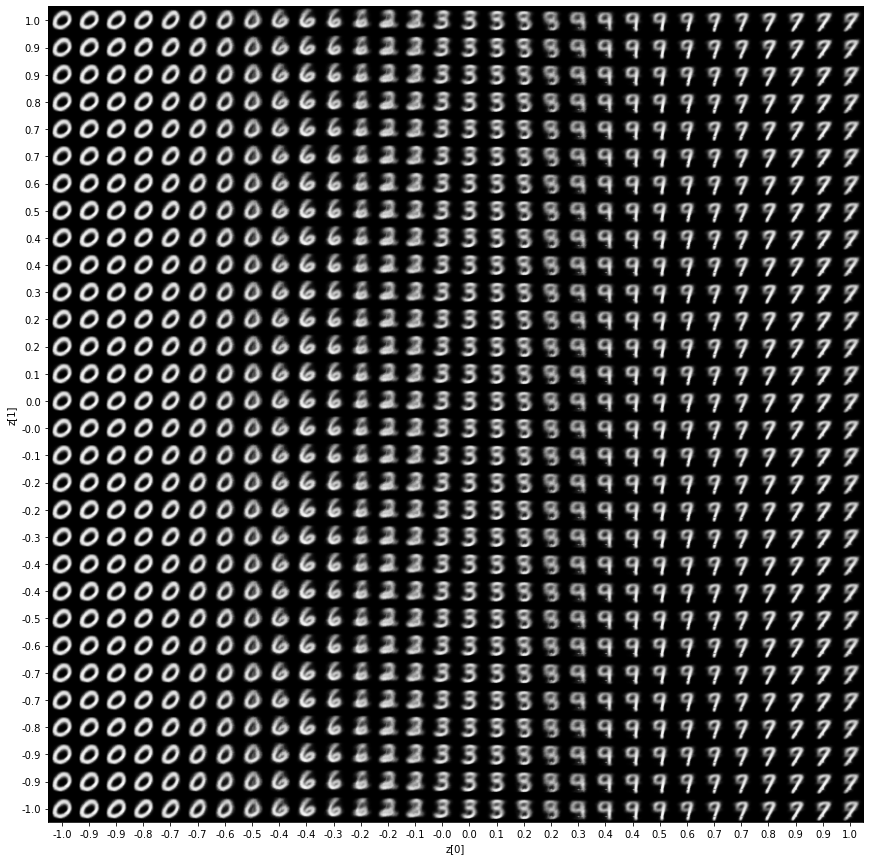

In [7]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

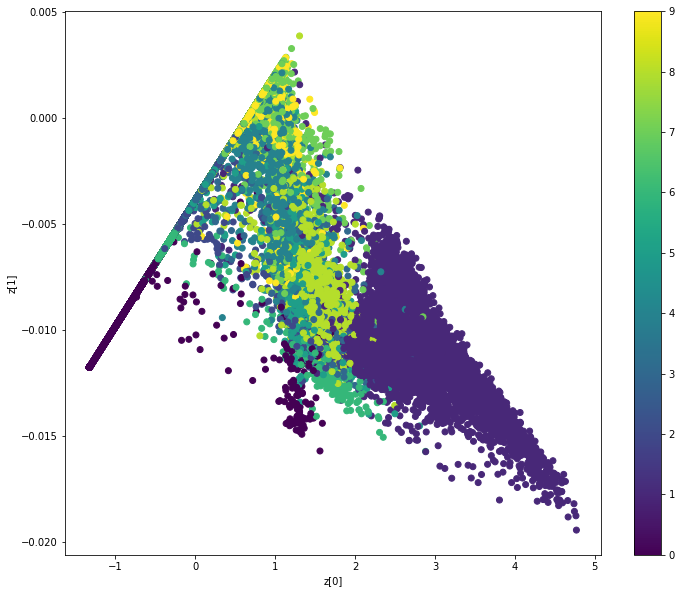

In [8]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)